In [1]:
import time 
import numpy as np
import importlib
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
train_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train', 'test'), batch_size=-1,
    as_supervised=True)

#Since the models aren't being tuned, I'm just going to use the test_data as validation data 
#If I was tuning while training then I'd set aside validation data to measure performance while training
#and then use the test set at the end to get the best possible measure of the model's performance on unseen data

In [3]:
xTrain, yTrain = tfds.as_numpy(train_data)
xTest, yTest = tfds.as_numpy(test_data)

In [4]:
#Use fewer rows of the data. You might want to do this if you're wanting fast results for prototyping
xTrain = xTrain[0:xTrain.shape[0]//4,]
yTrain = yTrain[0:yTrain.shape[0]//4]

xTest = xTest[0:xTest.shape[0]//8]
yTest = yTest[0:yTest.shape[0]//8]

In [5]:
print(xTrain.shape, yTrain.shape, xTest.shape, yTest.shape)

(6250,) (6250,) (3125,) (3125,)


In [6]:
max_features = 5000  # Maximum vocab size, i.e. the number of unique numbers in the int sequences. The embedding layer will also need this number  
max_len = 500  # Sequence length to trim/pad the outputs to. In RNN terms this is essentially the number of timesteps 

vectorize_layer = TextVectorization(max_tokens=max_features,output_sequence_length=max_len)

In [7]:
vectorize_layer.adapt(xTrain)

In [8]:
xTrainV = vectorize_layer(xTrain)
xTestV = vectorize_layer(xTest)
print(xTrainV.shape, xTestV.shape)

(6250, 500) (3125, 500)


## Train models 

In [9]:
#all models will be trained with this number of epochs and batch size, although some
#models may perform better with different batch sizes and some models may need more or
#less than the set number of epochs. Usually I would attach a earlystopping callback but for
#the purpose of plotting I want all the models to run for exactly the same number of epochs 
numEpochs = 10
batchSize = 512

In [10]:
#a dict to save the fit histories in
historyDicts = {}

### Model with locally trained embedding layer 

This model learns the embedding itself instead of using a pretrained embedding

In [11]:
embeddingDims = 16 #this is the length of the vectors resulting from the embedding.
#In terms of what the RNNs layers see, this is the number of features at each timestep 
#Each word (or rather, each word index) in each sentence will become a vector of length embeddingDims 

In [12]:
#you can make the vectorize layer the first layer of the network. If you do that, then you must pass
#the original data (xTrain, xTest) to .fit as opposed to the vectorized versions (xTrainV, xTestV)
#But doing the vectorization beforehand and passing xTrainV and xTestV makes training go faster since the 
#model doesn't have to vectorize on passes through the network 

inputs = keras.Input(shape=(max_len)) #when fst layer is LSTM use this: keras.Input(shape=(timesteps, numFeatures))
embedder = layers.Embedding(max_features+1, embeddingDims)(inputs)
averaging = layers.GlobalAveragePooling1D()(embedder)
#layers.Dropout(0.2),
denseLayer1 = layers.Dense(16)(averaging) #adding this layer actually decreases performance for this architecture
denseLayer2 = layers.Dense(1)(denseLayer1)
model = keras.Model(inputs, denseLayer2)

In [13]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0)])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 16)           80016     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 80,305
Trainable params: 80,305
Non-trainable params: 0
_________________________________________________________________


In [15]:
start = time.time()

#history = model.fit(xTrain,yTrain,validation_data=(xTest, yTest), epochs=10)

#If text vectorization was not put at start of model, use prevectorized version of data: 
lhistory = model.fit(xTrainV, yTrain, 
                    validation_data=(xTestV, yTest), 
                    #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)],
                    batch_size=batchSize, #for this model batch size 32 results in better performance 
                    epochs=numEpochs)

end = time.time()
print("Time elapsed (mins):", (end-start)/60)

Epoch 1/10
13/13 [==============================] - 1s 62ms/step - loss: 0.6931 - binary_accuracy: 0.5005 - val_loss: 0.6927 - val_binary_accuracy: 0.5126
Epoch 2/10
13/13 [==============================] - 1s 44ms/step - loss: 0.6925 - binary_accuracy: 0.5248 - val_loss: 0.6922 - val_binary_accuracy: 0.5149
Epoch 3/10
13/13 [==============================] - 1s 55ms/step - loss: 0.6916 - binary_accuracy: 0.5350 - val_loss: 0.6913 - val_binary_accuracy: 0.5898
Epoch 4/10
13/13 [==============================] - 1s 47ms/step - loss: 0.6905 - binary_accuracy: 0.5643 - val_loss: 0.6901 - val_binary_accuracy: 0.5178
Epoch 5/10
13/13 [==============================] - ETA: 0s - loss: 0.6884 - binary_accuracy: 0.567 - 1s 45ms/step - loss: 0.6884 - binary_accuracy: 0.5672 - val_loss: 0.6881 - val_binary_accuracy: 0.6701
Epoch 6/10
13/13 [==============================] - 1s 47ms/step - loss: 0.6856 - binary_accuracy: 0.7014 - val_loss: 0.6853 - val_binary_accuracy: 0.6544
Epoch 7/10
13/13 [==

In [16]:
historyDicts['local'] = lhistory.history
historyDicts['local']['trainTime'] = round((end - start)/60, 2)

### Pretrained embedding: Google NNLM 50

In [17]:
#I believe this hub model is also doing word level embedding, but the embeddings are avearged 
#to form a sentence level embedding 
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)

In [18]:
model = tf.keras.Sequential()
model.add(hub_layer)
#model.add(layers.GlobalAveragePooling1D()) #no pooling layer because one embedding per sentence 
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense_2 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0)])

In [21]:
start = time.time()

#pass the original instead of vectorized data, because the hub layer does tokenization itself
nnlm50history = model.fit(xTrain, yTrain,
                    validation_data=(xTest, yTest),
                    batch_size=batchSize,
                    epochs=numEpochs)
                    
end = time.time()
print("Time elapsed (mins):", (end-start)/60)

Epoch 1/10
13/13 [==============================] - 10s 741ms/step - loss: 0.7140 - binary_accuracy: 0.5245 - val_loss: 0.6814 - val_binary_accuracy: 0.5632
Epoch 2/10
13/13 [==============================] - 9s 676ms/step - loss: 0.6588 - binary_accuracy: 0.6248 - val_loss: 0.6542 - val_binary_accuracy: 0.6675
Epoch 3/10
13/13 [==============================] - 9s 668ms/step - loss: 0.6182 - binary_accuracy: 0.7637 - val_loss: 0.6231 - val_binary_accuracy: 0.7242
Epoch 4/10
13/13 [==============================] - 9s 668ms/step - loss: 0.5643 - binary_accuracy: 0.8186 - val_loss: 0.5772 - val_binary_accuracy: 0.7603
Epoch 5/10
13/13 [==============================] - 9s 671ms/step - loss: 0.4953 - binary_accuracy: 0.8477 - val_loss: 0.5282 - val_binary_accuracy: 0.7885
Epoch 6/10
13/13 [==============================] - 9s 671ms/step - loss: 0.4204 - binary_accuracy: 0.8787 - val_loss: 0.4819 - val_binary_accuracy: 0.8026
Epoch 7/10
13/13 [==============================] - 9s 669ms/st

In [22]:
historyDicts['nnlm50'] = nnlm50history.history
historyDicts['nnlm50']['trainTime'] = round((end - start)/60, 2)

### Pretrained embedding: Google NNLM 50 with normalization

In [23]:
model = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)

In [24]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_4 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0)])

In [27]:
start = time.time()

nnlm50normhistory = model.fit(xTrain, yTrain,
                    validation_data=(xTest, yTest),
                    batch_size=batchSize,
                    epochs=numEpochs)
                    
end = time.time()
print("Time elapsed (mins):", (end-start)/60)

Epoch 1/10
13/13 [==============================] - 9s 690ms/step - loss: 0.6903 - binary_accuracy: 0.5493 - val_loss: 0.6654 - val_binary_accuracy: 0.6294
Epoch 2/10
13/13 [==============================] - 9s 672ms/step - loss: 0.6392 - binary_accuracy: 0.7026 - val_loss: 0.6329 - val_binary_accuracy: 0.6874
Epoch 3/10
13/13 [==============================] - 9s 677ms/step - loss: 0.5932 - binary_accuracy: 0.7557 - val_loss: 0.5977 - val_binary_accuracy: 0.7254
Epoch 4/10
13/13 [==============================] - 9s 674ms/step - loss: 0.5399 - binary_accuracy: 0.7963 - val_loss: 0.5573 - val_binary_accuracy: 0.7581
Epoch 5/10
13/13 [==============================] - 9s 675ms/step - loss: 0.4798 - binary_accuracy: 0.8382 - val_loss: 0.5148 - val_binary_accuracy: 0.7846
Epoch 6/10
13/13 [==============================] - 9s 676ms/step - loss: 0.4160 - binary_accuracy: 0.8725 - val_loss: 0.4721 - val_binary_accuracy: 0.8032
Epoch 7/10
13/13 [==============================] - 9s 675ms/ste

In [28]:
historyDicts['nnlm50norm'] = nnlm50normhistory.history
historyDicts['nnlm50norm']['trainTime'] = round((end - start)/60, 2)

### Pretrained embedding: Google NNLM 128

In [29]:
model = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)

In [30]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 124,644,769
Trainable params: 124,644,769
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0)])

In [33]:
start = time.time()

nnlm128history = model.fit(xTrain, yTrain,
                    validation_data=(xTest, yTest),
                    batch_size=batchSize,
                    epochs=numEpochs)
                    
end = time.time()
print("Time elapsed (mins):", (end-start)/60)

Epoch 1/10
13/13 [==============================] - 26s 2s/step - loss: 0.6632 - binary_accuracy: 0.6243 - val_loss: 0.6234 - val_binary_accuracy: 0.7098
Epoch 2/10
13/13 [==============================] - 22s 2s/step - loss: 0.5565 - binary_accuracy: 0.8043 - val_loss: 0.5512 - val_binary_accuracy: 0.7645
Epoch 3/10
13/13 [==============================] - 22s 2s/step - loss: 0.4518 - binary_accuracy: 0.8683 - val_loss: 0.4748 - val_binary_accuracy: 0.8211
Epoch 4/10
13/13 [==============================] - 22s 2s/step - loss: 0.3499 - binary_accuracy: 0.9125 - val_loss: 0.4140 - val_binary_accuracy: 0.8432
Epoch 5/10
13/13 [==============================] - 22s 2s/step - loss: 0.2636 - binary_accuracy: 0.9390 - val_loss: 0.3718 - val_binary_accuracy: 0.8499
Epoch 6/10
13/13 [==============================] - 24s 2s/step - loss: 0.1937 - binary_accuracy: 0.9582 - val_loss: 0.3452 - val_binary_accuracy: 0.8538
Epoch 7/10
13/13 [==============================] - 40s 3s/step - loss: 0.14

In [34]:
historyDicts['nnlm128'] = nnlm128history.history
historyDicts['nnlm128']['trainTime'] = round((end - start)/60, 2)

# Plot accuracy

In [35]:
try:
    importlib.reload(historyPlotter) 
    #in jupyter environments it's best to reload libraries with importlib after they've been updated 
except:
    import historyPlotter

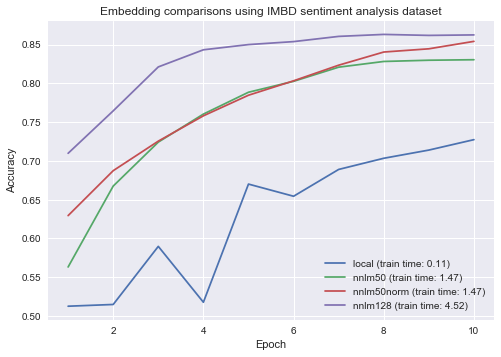

In [37]:
historyPlotter.valHistoryPlotter(historyDicts, 'Embedding comparisons using IMBD sentiment analysis dataset')

## Extras 

Predict on given sentence 

In [ ]:
def predOnReview(text):
    return model(vectorize_layer([text]))

In [ ]:
predOnReview('''
'This movie is the most worst awful disappointing amazing great fantastic movie Ive seen in my entire life'
''')

In [ ]:
predOnReview('''
 Buyer beware. Laptop arrived today, box was not damaged. Unboxed it, plugged in the charger, pressed the power button and nothing. Plug works and has other devices plugged in.
 ''')

Note about preprocessing 

The vectorization layer includes tokenization, but if you wanted to do it separately (to, for example, apply a pretrained embedder to words instead of sentences), you would use text.Tokenizer